<a href="https://colab.research.google.com/github/junghoum/Hello-world/blob/main/n223-evaluation-metrics-for-classification/n223a-evaluation-metrics-for-classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<img align="right" src="https://ds-cs-images.s3.ap-northeast-2.amazonaws.com/Codestates_Fulllogo_Color.png" width=100>

## *AIB / SECTION 2 / SPRINT 2 / NOTE 3*

# 📝 Assignment
---

# Evaluation Metrics for Classification

### 1) Kaggle 챌린지를 이어서 진행합니다.
- **다음 조건에서 F beta score를 구하고 제출하세요.**
    - TP = 4442, TN = 6165, FP = 1515, FN = 1930, 재현율에 정밀도의 2배 가중치를 부여합니다.

In [50]:
tp = 4442
tn = 6165
fp = 1515
fn = 1930
total = tp + tn + fp + fn 


In [60]:
positives = tp + fp
precision = tp/positives
#정밀도
precision

0.7456773543730065

In [61]:
real_positives = tp + fn
recall = tp / real_positives
#재현율
recall

0.697112366603892

In [63]:
def my_fbeta_score(precision, recall, beta=1.0):
  return(1.0 + (beta**2)) * (precision * recall) / (((beta**2) * precision) + recall)

In [66]:
beta=2

print('f beta score: ', my_fbeta_score(precision, recall, beta))

f beta score:  0.7063126093178566


In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

target = 'vacc_h1n1_f'
# target = 'vacc_seas_f'
train = pd.merge(pd.read_csv('https://ds-lecture-data.s3.ap-northeast-2.amazonaws.com/vacc_flu/train.csv'), 
                 pd.read_csv('https://ds-lecture-data.s3.ap-northeast-2.amazonaws.com/vacc_flu/train_labels.csv')[target], left_index=True, right_index=True)
test = pd.read_csv('https://ds-lecture-data.s3.ap-northeast-2.amazonaws.com/vacc_flu/test.csv')
sample_submission = pd.read_csv('https://ds-lecture-data.s3.ap-northeast-2.amazonaws.com/vacc_flu/submission.csv')

In [2]:
from sklearn.model_selection import train_test_split

train, val = train_test_split(train, train_size=0.80, test_size=0.20, 
                              stratify=train[target], random_state=2)


train.shape, val.shape, test.shape

((33723, 39), (8431, 39), (28104, 38))

In [3]:
def engineer(df):
  behaviorals = [col for col in df.columns if 'behavioral' in col]
  df['behaviorals'] = df[behaviorals].sum(axis=1)

  dels = [col for col in df.columns if ('employment' in col or 'seas' in col)]

  return df

train = engineer(train)
val = engineer(val)
test = engineer(test)

In [4]:
features = train.drop(columns=[target]).columns

X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]
X_test = test[features]

In [5]:
! pip install --upgrade category_encoders



In [27]:
from sklearn.pipeline import make_pipeline
from category_encoders import OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# 파이프라인을 만들어 봅시다.
pipe = make_pipeline(
    OrdinalEncoder(), 
    SimpleImputer(), 
    RandomForestClassifier(n_estimators=100, random_state=2, n_jobs=-1)
)


pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_val)
print('검증 정확도: ', accuracy_score(y_val, y_pred))

검증 정확도:  0.8282528762898825


In [49]:
real_positives = TP + FN
real_positives

2015

In [23]:
from sklearn.metrics import classification_report
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.85      0.94      0.89      6416
           1       0.72      0.46      0.56      2015

    accuracy                           0.83      8431
   macro avg       0.78      0.70      0.73      8431
weighted avg       0.82      0.83      0.81      8431



In [7]:
def my_f1_score(precision, recall):
  return 2.0 / (1/precision + 1/recall)

In [37]:
precision = 0.85
recall = 0.94

print('f1 score: ', my_f1_score(precision, recall))

f1 score:  0.8927374301675977


In [41]:
def my_fbeta_score(precision, recall, beta=1.0):
  return(1.0 + (beta**2)) * (precision * recall) / (((beta**2) * precision) + recall)

In [43]:
precision = 0.85
recall = 0.94
beta = 2
print('f1 beta score: ', my_fbeta_score(precision, recall, beta))

f1 beta score:  0.9205069124423962


### 2) 모델을 학습한 후 Confusion matrix를 그리고 해석하세요
- 임계값을 조정한 후 confusion matrix를 그려보세요
- **(객관식) 임계값을 증가시킬때 positive 범주에 대한 재현율의 변화 양상을 제출하세요.**
    1. 증가
    2. 감소
    3. 변화가 없다


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


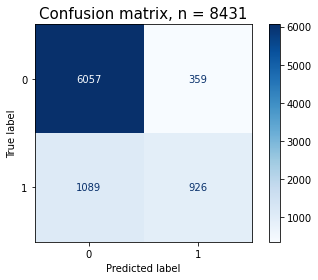

In [67]:
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
pcm = plot_confusion_matrix(pipe, X_val, y_val,
                            cmap=plt.cm.Blues,
                            ax=ax);
plt.title(f'Confusion matrix, n = {len(y_val)}', fontsize=15)
plt.show()

In [68]:
from ipywidgets import interact, fixed
from sklearn.metrics import classification_report

y_pred_proba = pipe.predict_proba(X_val)[:, 1] # 타겟이 1(True)일 확률
def conf_matrix(y_true, y_pred_proba, threshold=0.5):
  y_pred = y_pred_proba > threshold

  fig, ax = plt.subplots()
  pcm = plot_confusion_matrix(pipe, X_val, y_pred,
                              cmap=plt.cm.Blues,
                              ax=ax);
  plt.title(f'Confusion matrix, n = {len(y_pred)}', fontsize=15)
  plt.show()

  print(classification_report(y_true, y_pred))


interact(conf_matrix, y_true=fixed(y_val), y_pred_proba=fixed(y_pred_proba), threshold=(0, 1, 0.01));

interactive(children=(FloatSlider(value=0.5, description='threshold', max=1.0, step=0.01), Output()), _dom_cla…

### 3) 랜덤포레스트의 n_estimator를 1, 10, 100, 1000으로 바꾸어 가며 positive 범주의 predict_proba를 비교해 보세요
- 하이퍼파라미터는 다음과 같이 설정합니다.
    - n_jobs=-1, random_state=10, max_depth=None, oob_score=True
- **(객관식) 확률값들의 분포의 변화를 아래 보기 중에서 고르세요**
    1. 다양해진다
    2. 변화가없다


In [75]:
import seaborn as sns

def ctrl_estimator(n_estimators=1):
  pipe = make_pipeline(
    OrdinalEncoder(), 
    SimpleImputer(), 
    RandomForestClassifier(n_estimators=n_estimators, n_jobs=-1, random_state=10, max_depth=None, oob_score=True)
  )

  pipe.fit(X_train, y_train)
  
  y_pred_proba = pipe.predict_proba(X_val)[:, 1]
  sns.displot(y_pred_proba);
        
interact(ctrl_estimator, n_estimators=(1));
interact(ctrl_estimator, n_estimators=(10));
interact(ctrl_estimator, n_estimators=(100));
interact(ctrl_estimator, n_estimators=(10000));


interactive(children=(IntSlider(value=1, description='n_estimators', max=3, min=-1), Output()), _dom_classes=(…

interactive(children=(IntSlider(value=10, description='n_estimators', max=30, min=-10), Output()), _dom_classe…

interactive(children=(IntSlider(value=100, description='n_estimators', max=300, min=-100), Output()), _dom_cla…

interactive(children=(IntSlider(value=10000, description='n_estimators', max=30000, min=-10000), Output()), _d…

### 4) 두개 이상의 다른 분류 모델을 학습시켜 ROC curve, AUC 점수를 비교하고 설명합니다.
- 더 좋은 결과가 나오는 모델을 사용해서 캐글에 제출하세요
- **캐글 Leaderboard의 본인 Score를 제출하세요.**

In [74]:
from sklearn.metrics import roc_curve

# roc_curve(타겟값, prob of 1)
fpr, tpr, thresholds = roc_curve(y_val, y_pred_proba)

roc = pd.DataFrame({
    'FPR(Fall-out)': fpr, 
    'TPRate(Recall)': tpr, 
    'Threshold': thresholds
})
roc

,FPR(Fall-out),TPRate(Recall),Threshold
0,0.000000,0.000000,2.000000
1,0.000000,0.000993,1.000000
2,0.000000,0.002481,0.980000
3,0.000000,0.003474,0.974000
4,0.000000,0.003970,0.973333
...,...,...,...
346,0.910692,0.989578,0.023750
347,0.953398,0.994541,0.020000
348,0.953709,0.994541,0.015000
349,0.984882,0.997519,0.010000


In [76]:
# threshold 최대값의 인덱스, np.argmax()
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]

print('idx:', optimal_idx, ', threshold:', optimal_threshold)

idx: 220 , threshold: 0.27899999999999997


In [77]:
from sklearn.metrics import roc_auc_score
auc_score = roc_auc_score(y_val, y_pred_proba)
auc_score

0.8313881471878617

In [80]:

# 최종 모델 학습 후 테스트 셋에 대한 예측 결과
y_pred_proba = pipe.predict_proba(X_test)[:, 1] # 타겟이 1(True)일 확률 가져오기
y_test_pred = y_pred_proba > optimal_threshold

In [82]:
df = {'Id':X_test.index, 'vacc_h1n1_f': y_test_pred}
submission = pd.DataFrame(data = d)
submission.head()

,Id,vacc_h1n1_f
0,0,False
1,1,False
2,2,False
3,3,False
4,4,False


In [86]:
submission.to_csv('submission.csv', index=False)

## 🔥 도전과제

### 5) 각 평가지표에 대해 결과를 최대한 분석하고 무엇이 부족한지, 어떤 방향으로 성능을 높여야 하는지 논하세요.

In [ ]:
### 이곳에서 과제를 진행해 주세요 ### 